# Build classification models that use a combination of the PCA components and the original dataset

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score, classification_report
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
xgb.set_config(verbosity=0)
from sklearn.feature_selection import RFECV
import random
from scipy import stats
from sklearn.model_selection import train_test_split 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Preprocessing

In [4]:
df = pd.read_csv("dataset\CSF_Proteomics_ADNI.csv")

#replace categorical feature with index labeling
df['binary_class'].replace({'stable':0,'decliner':1},inplace=True)
df['three_class'].replace({'slowDecline':0,'rapidDecline':1,'stable':2},inplace=True)

#differentiate other categorical features from the numerical ones
pheno = df.loc[:,'RID':'VISCODE']
data = df.loc[:,'A1AT.AVLTIDEK':'VTDB.VPTADLEDVLPLAEDITNILSK']

## Normalization

#normally test function -> check if each column is normally distr
def norm_test(data):
    alpha = 1e-3
    k2, p = stats.normaltest(data)
    count=0
    for i in p:
        if i > alpha:  # null hypothesis: x comes from a normal distribution
            count+=1
    print('There are ',count,'normally distributed features out of',data.shape[1])

#QUANTILE NORMALIZATION
def quantile_normalize(df):
    df_sorted = pd.DataFrame(np.sort(df.values,axis=0),index=df.index,columns=df.columns)
    df_mean = df_sorted.mean(axis=1)
    df_mean.index = np.arange(1, len(df_mean) + 1)
    df_qn =df.rank(method="min").stack().astype(int).map(df_mean).unstack()
    return df_qn

# compute quantile normalized data
df_qn=quantile_normalize(data)
data = df_qn

## Split dataset

X = data
y = df["binary_class"]

## Test models using with original dataset + PCA

In [5]:
from sklearn.decomposition import PCA

# Make an instance of the Model keeping 95% of the features variance is retained
pca = PCA(.80)

principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)

new_X = pd.concat([X.reset_index(drop=True), principalDf.reset_index(drop=True)], axis=1)

#fill NaN values with mean of 
print('Note that we now have',new_X.shape[1],'columns instead of',X.shape[1],'(origin dataset + PCA components)')

X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size = 0.20, random_state = 97)

Note that we now have 333 columns instead of 320 (origin dataset + PCA components)


### Single xgb classifier

In [6]:
def XGB_class(X_train, X_test, y_train, y_test,learning_rate, n_estimators, max_depth,min_child_weight, gamma, subsample, colsample_bytree, simple):
    
    if simple:
        clf = xgb.XGBClassifier(seed = 24, use_label_encoder =False)
    else:
        clf = xgb.XGBClassifier(learning_rate = learning_rate, n_estimators = int(n_estimators), max_depth = int(max_depth), 
                                min_child_weight = min_child_weight, gamma = gamma, subsample = subsample, 
                                colsample_bytree = colsample_bytree, seed = 24,eval_metric='mlogloss',use_label_encoder =False)

    clf.fit(X_train, y_train)
    y_predicted = clf.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_predicted))
    print(classification_report(y_test, y_predicted))

In [7]:
XGB_class(X_train,X_test,y_train,y_test,0,0,0,0,0,0,0,simple=True)

Accuracy: 0.7407407407407407
              precision    recall  f1-score   support

           0       0.83      0.45      0.59        11
           1       0.71      0.94      0.81        16

    accuracy                           0.74        27
   macro avg       0.77      0.70      0.70        27
weighted avg       0.76      0.74      0.72        27



### SVM

In [8]:
clf = SVC(kernel='linear') 
  
# fitting x samples and y classes 
clf.fit(X_train, y_train) 
y_predicted = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_predicted))
print(classification_report(y_test, y_predicted))

Accuracy: 0.7037037037037037
              precision    recall  f1-score   support

           0       0.64      0.64      0.64        11
           1       0.75      0.75      0.75        16

    accuracy                           0.70        27
   macro avg       0.69      0.69      0.69        27
weighted avg       0.70      0.70      0.70        27



C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


### Single Random Forest classifier

In [9]:
# evaluate random forest algorithm for classification
# define the model
model = RandomForestClassifier().fit(X_train,y_train)
y_predicted = model.predict(X_test)
# report performance
print("Accuracy:", accuracy_score(y_test, y_predicted))
print(classification_report(y_test, y_predicted))

Accuracy: 0.7037037037037037
              precision    recall  f1-score   support

           0       0.80      0.36      0.50        11
           1       0.68      0.94      0.79        16

    accuracy                           0.70        27
   macro avg       0.74      0.65      0.64        27
weighted avg       0.73      0.70      0.67        27



C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


### Logistic Regression

In [10]:
model = LogisticRegression(random_state=0).fit(X_train, y_train)
y_predicted = model.predict(X_test)
# report performance
print("Accuracy:", accuracy_score(y_test, y_predicted))
print(classification_report(y_test, y_predicted))

Accuracy: 0.6296296296296297
              precision    recall  f1-score   support

           0       0.55      0.55      0.55        11
           1       0.69      0.69      0.69        16

    accuracy                           0.63        27
   macro avg       0.62      0.62      0.62        27
weighted avg       0.63      0.63      0.63        27



C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\marti\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


### RFE

In [11]:
def rfe_xgb(X_train, y_train,learning_rate, n_estimators, max_depth,min_child_weight, gamma, subsample, colsample_bytree, simple):
    min_features_to_select = 1
    
    #run RFE on current train subset
    if simple:
        clf = xgb.XGBClassifier(seed = 24, use_label_encoder =False)
    else:
        clf = xgb.XGBClassifier(learning_rate = learning_rate, n_estimators = int(n_estimators), max_depth = int(max_depth), 
                                min_child_weight = min_child_weight, gamma = gamma, subsample = subsample, 
                                colsample_bytree = colsample_bytree, seed = 24,eval_metric='mlogloss',use_label_encoder =False)
    rfecv = RFECV(estimator=clf,min_features_to_select=min_features_to_select,step=3,n_jobs=-1,scoring="r2",cv=5)
    rfecv.fit(X_train, y_train)
    
    #keep selected features + check RFE accuracy scores during running
    newX_train = X_train[X_train.columns[rfecv.support_]]
    newX_test = X_test[X_test.columns[rfecv.support_]]
    print('We kept',newX_train.shape[1],'features out of the',X_train.shape[1])

    plt.figure()
    lines = []
    for i in range(rfecv.grid_scores_.shape[1]):
        lines.append(plt.plot(rfecv.grid_scores_[:,i]))

    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (accuracy)")
    plt.legend(lines,labels = ['fold 1', 'fold 2', 'fold 3','fold 4', 'fold 5'],loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    return newX_train,newX_test

### Test on single XGB classifier using RFE selected features

C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


We kept 60 features out of the 333


C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(m

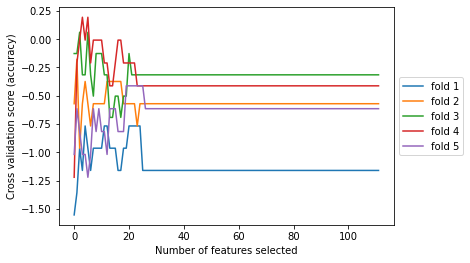

Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.62      0.45      0.53        11
           1       0.68      0.81      0.74        16

    accuracy                           0.67        27
   macro avg       0.65      0.63      0.63        27
weighted avg       0.66      0.67      0.65        27

['A1AT.AVLTIDEK', 'A1AT.LSITGTYDLK', 'A1AT.SVLGQLGITK', 'AACT.ADLSGITGAR', 'AFAM.FLVNLVK', 'AFAM.LPNNVLQEK', 'ALDOA.ALQASALK', 'AMBP.ETLLQDFR', 'APOE.AATVGSLAGQPLQER', 'APOE.LGADMEDVR', 'APOE.LGPLVEQGR', 'BTD.LSSGLVTAALYGR', 'CAD13.INENTGSVSVTR', 'CAH1.VLDALQAIK', 'CATA.LFAYPDTHR', 'CCKN.AHLGALLAR', 'CD59.AGLQVYNK', 'CMGA.SGEATDGARPQALPEPMQESK', 'CNTN1.DGEYVVEVR', 'CNTN2.IIVQAQPEWLK', 'CNTP2.HELQHPIIAR', 'CO3.IHWESASLLR', 'CO3.TGLQEVEVK', 'COCH.GVISNSGGPVR', 'CSTN3.ATGEGLIR', 'ENOG.GNPTVEVDLYTAK', 'ENPP2.SYPEILTLK', 'FETUA.FSVVYAK', 'FMOD.YLPFVPSR', 'GFAP.ALAAELNQLR', 'GOLM1.QQLQALSEPQPR', 'HBB.SAVTALWGK', 'KLK6.ESSQEQSSVVR', 'KPYM.LDID

In [12]:
#test rfe then simple XGB classifier
newX_train,newX_test = rfe_xgb(X_train, y_train,0,0,0,0,0,0,0,simple=True)
XGB_class(newX_train,newX_test,y_train,y_test,0,0,0,0,0,0,0,simple=True)
print(list(newX_train.columns))
print('Note that we kept both columns from the original dataset and the PCA components')

C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


We kept 78 features out of the 375


C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(m

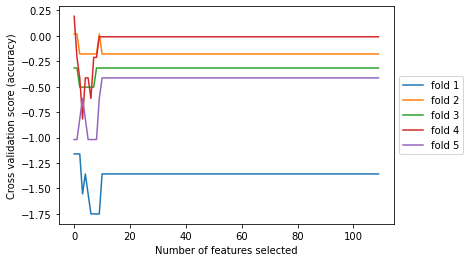

This is number 0 generation
Best Accuracy score in the this iteration = 0.7778
[2]
This is number 1 generation
Best Accuracy score in the this iteration = 0.7778
[2]
This is number 2 generation
Best Accuracy score in the this iteration = 0.7778
[1]
This is number 3 generation
Best Accuracy score in the this iteration = 0.7778
[2]
This is number 4 generation
Best Accuracy score in the this iteration = 0.7778
[4]
This is number 5 generation
Best Accuracy score in the this iteration = 0.7778
[1]
This is number 6 generation
Best Accuracy score in the this iteration = 0.7778
[2]
This is number 7 generation
Best Accuracy score in the this iteration = 0.7778
[4]
This is number 8 generation
Best Accuracy score in the this iteration = 0.7778
[1]
This is number 9 generation
Best Accuracy score in the this iteration = 0.7778
[3]
This is number 10 generation
Best Accuracy score in the this iteration = 0.7778
[0]
This is number 11 generation
Best Accuracy score in the this iteration = 0.7778
[0]
Th

In [128]:
#test tuning XGB hyperparameters with selected features from RFE
newX_train,newX_test = rfe_xgb(X_train, y_train,0,0,0,0,0,0,0,simple=True)
learning_rate, n_estimators, max_depth, min_child_weight,gamma, subsample,colsample_bytree = hyp_param_ev_algo(newX_train, newX_test, y_train, y_test)
XGB_class(newX_train,newX_test,y_train,y_test,learning_rate, n_estimators, max_depth, min_child_weight,gamma, subsample,colsample_bytree,simple=False)